<a href="https://colab.research.google.com/github/jafr0822/MNA_ProyectoIntegrador-Equipo7/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Leemos nuestro dataset cluster.csv

df = pd.read_csv("/content/Data/clusters.csv", encoding='utf-8', delimiter=';')

# Definimos las variables que fungieran como características (X) y la variable objetivo (y)
X = df.drop(columns=['IndexMorbilidad', 'EscalaRiesgo', "id_gdg", "origen_px"])
y = df['EscalaRiesgo']

# Escalamos las características a fin de reducir el rando de valores
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



## Dividimos nuestro conjunto de datos en datos de entrenamiento y validación. Asimismo, aplicamos la técnica de validación cruzada a fin de evitar el sobre ajuste.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## Definimos nuestro modelo y los parámetros, en este caso usaremos un modelo lineal.

In [23]:
svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(svm, param_grid, refit=True, verbose=3, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.664 total time=   0.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.5s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.662 total time=   0.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.662 total time=   0.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.662 total time=   0.5s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.986 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.982 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.995 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.995 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.995 total time=   0.2s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.664 total time=   0.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=3)

## Evaluamos nuestro modelo en el conjunto de prueba, para ello generamos la matriz de confusión, el informe de clasificación y la curva ROC.

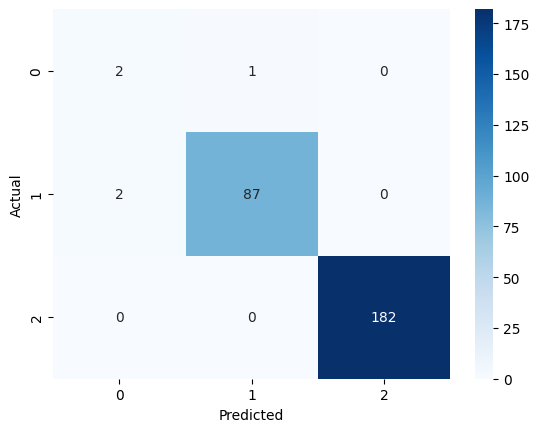

              precision    recall  f1-score   support

           A       0.50      0.67      0.57         3
           B       0.99      0.98      0.98        89
           C       1.00      1.00      1.00       182

    accuracy                           0.99       274
   macro avg       0.83      0.88      0.85       274
weighted avg       0.99      0.99      0.99       274



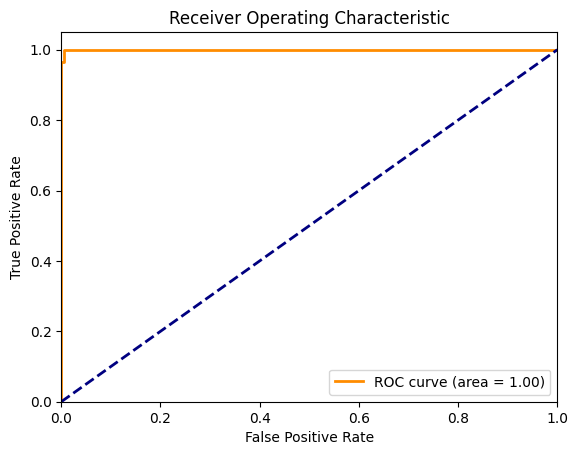

In [24]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]  # Probabilidades para ROC

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Informe de Clasificación
print(classification_report(y_test, y_pred))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=grid.classes_[1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Aplicamos nuevamente la validación cruzada pero ahora incorporamos las métricas que nos arrojó el modelo.

In [25]:
from sklearn.model_selection import cross_val_score

# Accuracy
acc_scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=skf, scoring='accuracy')
print(f'Accuracy: {acc_scores.mean()} (+/- {acc_scores.std() * 2})')

# Precision
precision_scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=skf, scoring='precision_macro')
print(f'Precision: {precision_scores.mean()} (+/- {precision_scores.std() * 2})')

# Recall
recall_scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=skf, scoring='recall_macro')
print(f'Recall: {recall_scores.mean()} (+/- {recall_scores.std() * 2})')

# F1 Score
f1_scores = cross_val_score(grid.best_estimator_, X_scaled, y, cv=skf, scoring='f1_macro')
print(f'F1 Score: {f1_scores.mean()} (+/- {f1_scores.std() * 2})')


Accuracy: 0.9919708029197081 (+/- 0.010727692304159837)
Precision: 0.9340796029197289 (+/- 0.1745560537154893)
Recall: 0.8844194756554307 (+/- 0.20214232642206398)
F1 Score: 0.8947169966245486 (+/- 0.1683570835283669)


Realizamos la evaluación final y la optimización de parámetros del modelo líneal para ver cuáles son los parámetros ideales, así como el mejor accuracy.

In [26]:
print("Best Parameters found: ", grid.best_params_)
print("Best Cross Validation Accuracy: ", grid.best_score_)


Best Parameters found:  {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Best Cross Validation Accuracy:  0.9908800332088002
